In [1]:
from cnn.model import build_net

from spleen_dataset.dataloader import SpleenDataloader, SpleenDataset, get_training_augmentation, get_validation_augmentation
from spleen_dataset.config import dataset_folder
from spleen_dataset.utils import get_split_deterministic, get_list_of_patients

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import random
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    #tf.config.experimental.set_memory_growth(gpus[0], False)
  except RuntimeError as e:
    print(e)

2022-09-10 11:44:35.932330: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 11:44:35.962436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 11:44:35.962569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
patients = get_list_of_patients(dataset_folder)

In [3]:
patch_size = (128, 128)
batch_size = 32
num_classes = 2
train_augmentation = get_training_augmentation(patch_size)
val_augmentation = get_validation_augmentation(patch_size)

net_list = [
    'xception_3_32', 
    'xception_3_64',
    'xception_3_64',
    'xception_3_256',
    'xception_3_512',
    'xception_3_256',
    'xception_3_128',
    'xception_3_64',
    'xception_3_32'
]

fn_dict = {
    'vgg_3_32':       {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 32},  'prob': 1/36},
    'vgg_3_64':       {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 64},  'prob': 1/36},
    'vgg_3_128':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 128}, 'prob': 1/36},
    'vgg_3_256':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 256}, 'prob': 1/36},
    'vgg_3_512':      {'block': 'VGGBlock',      'params': {'kernel': 3, 'filters': 512}, 'prob': 1/36},
    'resnet_3_32':    {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 32},  'prob': 1/36},
    'resnet_3_64':    {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 64},  'prob': 1/36},
    'resnet_3_128':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 128}, 'prob': 1/36},
    'resnet_3_256':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 256}, 'prob': 1/36},
    'resnet_3_512':   {'block': 'ResNetBlock',   'params': {'kernel': 3, 'filters': 512}, 'prob': 1/36},
    'xception_3_32':  {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 32},  'prob': 1/36},
    'xception_3_64':  {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 64},  'prob': 1/36},
    'xception_3_128': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 128}, 'prob': 1/36},
    'xception_3_256': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 256}, 'prob': 1/36},
    'xception_3_512': {'block': 'XceptionBlock', 'params': {'kernel': 3, 'filters': 512}, 'prob': 1/36},
    'mbconv_3_32':    {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 32},  'prob': 1/36},
    'mbconv_3_64':    {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 64},  'prob': 1/36},
    'mbconv_3_128':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 128}, 'prob': 1/36},
    'mbconv_3_256':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 256}, 'prob': 1/36},
    'mbconv_3_512':   {'block': 'MBConvBlock',   'params': {'kernel': 3, 'filters': 512}, 'prob': 1/36},
}

2022-09-10 11:45:14.673450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-10 11:45:14.673999: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 11:45:14.674195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-10 11:45:14.674290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Epoch 1/50


2022-09-10 11:45:20.697901: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-09-10 11:45:22.138587: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


26/26 [==============================] - 16s 368ms/step - loss: 0.9086 - gen_dice_coef: 0.0914 - val_loss: 0.7373 - val_gen_dice_coef: 0.2627
Epoch 2/50
26/26 [==============================] - 5s 183ms/step - loss: 0.6127 - gen_dice_coef: 0.3873 - val_loss: 0.4650 - val_gen_dice_coef: 0.5350
Epoch 3/50
26/26 [==============================] - 5s 183ms/step - loss: 0.4641 - gen_dice_coef: 0.5359 - val_loss: 0.3963 - val_gen_dice_coef: 0.6037
Epoch 4/50
26/26 [==============================] - 5s 177ms/step - loss: 0.3776 - gen_dice_coef: 0.6224 - val_loss: 0.3605 - val_gen_dice_coef: 0.6395
Epoch 5/50
26/26 [==============================] - 5s 185ms/step - loss: 0.3479 - gen_dice_coef: 0.6521 - val_loss: 0.3458 - val_gen_dice_coef: 0.6542
Epoch 6/50
26/26 [==============================] - 5s 176ms/step - loss: 0.3218 - gen_dice_coef: 0.6782 - val_loss: 0.4084 - val_gen_dice_coef: 0.5916
Epoch 7/50
26/26 [==============================] - 5s 185ms/step - loss: 0.2956 - gen_dice_coef: 

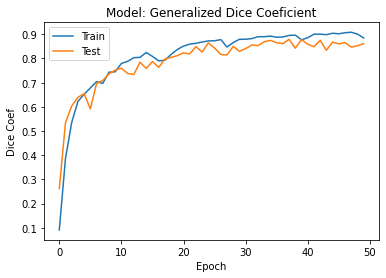

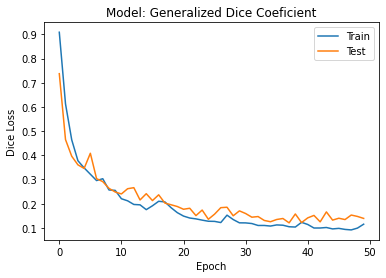

Epoch 1/50
22/26 [========================>.....] - ETA: 0s - loss: 0.9139 - gen_dice_coef: 0.0861

In [4]:
val_gen_dice_coef_list = []
num_splits = 5
num_initializations = 3
epochs = 50

for initialization in range(num_initializations):

    for fold in range(num_splits):
        train_patients, val_patients = get_split_deterministic(patients, fold=fold, num_splits=num_splits, random_state=initialization)

        train_dataset = SpleenDataset(train_patients, only_non_empty_slices=True)
        val_dataset = SpleenDataset(val_patients, only_non_empty_slices=True)

        train_dataloader = SpleenDataloader(train_dataset, batch_size, train_augmentation)
        val_dataloader = SpleenDataloader(val_dataset, batch_size, val_augmentation)

        model = build_net((*patch_size, 1), num_classes, fn_dict, net_list)

        checkpoint_filepath = '/tmp/checkpoint'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_gen_dice_coef',
            mode='max',
            save_best_only=True)

        history = model.fit(
            train_dataloader,
            validation_data=val_dataloader,
            epochs=epochs,
            verbose=1,
            callbacks=[
                model_checkpoint_callback
            ]
        )

        model.load_weights(checkpoint_filepath)

        for patient in val_patients:
            patient_dataset = SpleenDataset([patient], only_non_empty_slices=True)
            patient_dataloader = SpleenDataloader(patient_dataset, 1, val_augmentation, shuffle=False)
            results = model.evaluate(patient_dataloader)
            val_gen_dice_coef_patient = results[-1]
            val_gen_dice_coef_list.append(val_gen_dice_coef_patient)

        #plotting the dice coef results (accuracy) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['gen_dice_coef'])
        plt.plot(history.history['val_gen_dice_coef'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Coef')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        #plotting the dice coeff results (loss function) as a function of the number of epochs
        plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model: Generalized Dice Coeficient')
        plt.ylabel('Dice Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper right')
        plt.show()

mean_val_gen_dice_coef = (np.mean(val_gen_dice_coef_list))
std_val_gen_dice_coef = (np.std(val_gen_dice_coef_list))

print(f'Dice {mean_val_gen_dice_coef} +- {std_val_gen_dice_coef}')

In [ ]:
#!tensorboard --logdir='./logs'